In [1]:
# ! pip install ultralytics opencv-python numpy

In [1]:
from ultralytics import YOLO
from utils import *
import cv2

In [2]:
YOLO_MODEL_NAME = 'models/yolov8n.pt'
IMG = "image/4.jpg"        # Using the fast Nano model as an example

model = YOLO(YOLO_MODEL_NAME)
print(f"Model loaded: {YOLO_MODEL_NAME}")


Model loaded: models/yolov8n.pt


In [4]:
from matplotlib import pyplot as plt

class YoloFaceDetector:
    def __init__(self, model_path=YOLO_MODEL_NAME, conf_threshold=0.5):
        self.model = YOLO(model_path)
        self.conf_threshold = conf_threshold

    def detect_faces(self, image):
        results = self.model.predict(image, save=False, verbose=False, conf=self.conf_threshold)
        return results
    
    def add_noise_annotate(self, image, sigma: list):
        noisy_images = [add_gaussian_noise(image, sigma=s) for s in sigma]
        annotated_images = [draw_yolo_boxes(self.detect_faces(img), img) for img in noisy_images]
        return annotated_images

    def show(self, image_path, SIGMA):
        image = read_image(image_path)
        annotated_images = self.add_noise_annotate(image, SIGMA)

        plt.figure(figsize=(18,12))
        for i, (s, img) in enumerate(zip(SIGMA, annotated_images)):
            plt.subplot(1, 6, i + 1)
            plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
            if i == 0:
                plt.title(f'Grount Truth')
            else: 
                plt.title(f'Sigma: {s}')
            plt.axis('off')
        plt.show()

In [ ]:
SIGMA = [0, 0.1, 0.13, 0.15, 0.3, 1.0]

if __name__ == "__main__":
    img_path = "image/group.jpg"
    yolo = YoloFaceDetector()

In [40]:
def add_gaussian_blur(image: np.ndarray, kernel_size: int) -> np.ndarray:
    """
    Applies Gaussian blur to the image.
    Kernel size must be a positive odd integer. If 0, original image is returned.
    """
    if kernel_size <= 1:
        return image.copy()
    
    # Ensure kernel size is odd
    if kernel_size % 2 == 0:
        # If it's even, make it the next odd number (e.g., 4 becomes 5)
        kernel_size += 1
    
    blurred_image = cv2.GaussianBlur(image, (kernel_size, kernel_size), 0)
    return blurred_image

def add_jpeg_compression(image: np.ndarray, quality_factor: int) -> np.ndarray:
    """
    Applies JPEG compression degradation to the image using a quality factor.
    Quality factor must be an integer between 0 (worst quality) and 100 (best quality).
    If quality_factor is 100, the original image is essentially returned (lossless).
    """
    encode_param = [int(cv2.IMWRITE_JPEG_QUALITY), quality_factor]

    is_success, encoded_image = cv2.imencode('.jpg', image, encode_param)

    if not is_success:
        print("Warning: JPEG encoding failed. Returning original image.")
        return image.copy()

    # 3. Decode the image (decompression, which reveals artifacts)
    compressed_image = cv2.imdecode(encoded_image, cv2.IMREAD_COLOR)

    return compressed_image

In [ ]:
def _show(images, values, noise_type, robustness_metrics):

    plt.figure(figsize=(18,12))
    for i, (s, img) in enumerate(zip(values, images)):
        plt.subplot(1, 6, i + 1)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        if i == 0:
            plt.title(f'Ground Truth')
        else:
            plt.title(f'Sigma: {s}')
        plt.axis('off')
    plt.show()

"""
Metadata:
sigma: list of sigma values used for Gaussian noise
quality_factor: list of quality factors used for JPEG compression

Values:list => sigma, quality_factor, blur_kernel_size
type : str => gaussian_noise, jpeg_compression, motion_blur
Robustness Metrics:
"""

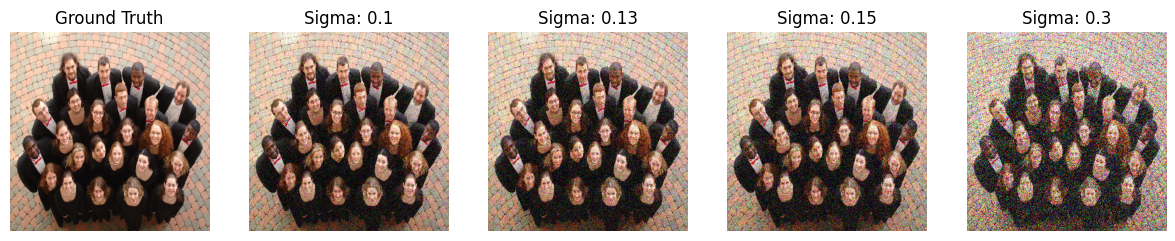

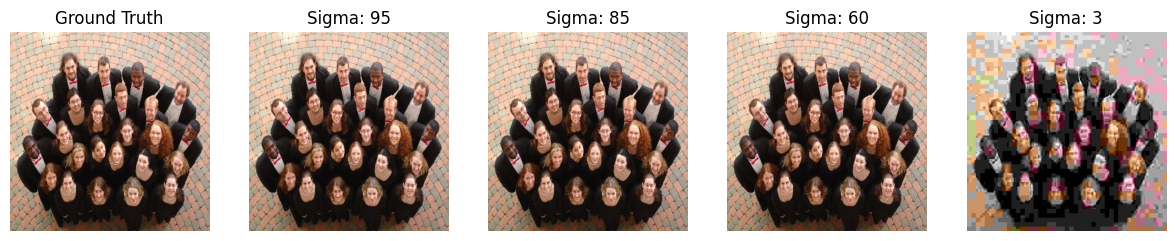

In [43]:
SIGMA = [0, 0.1, 0.13, 0.15, 0.3, 1.0]
COMPRESSION = [100, 95, 85, 60, 3, 1]

jpeg_compressed = []
gaussian_noise = []

img1 = read_image("image/grp-photo.jpg")

for i in range(5):
    noi = add_jpeg_compression(img1, quality_factor=COMPRESSION[i])
    jpeg_compressed.append(noi)
    gaussian_noise.append(add_gaussian_noise(img1, sigma=SIGMA[i]))

_show(SIGMA, gaussian_noise)
_show(COMPRESSION, jpeg_compressed)

In [67]:
img = 'image/grp-photo.jpg'
img1 = read_image(img)

GT = model.predict(img1, save=False, verbose=False, conf=0.5)

predicted_gaussian = [model.predict(img, save=False, verbose=False, conf=0.5) for img in gaussian_noise]
predicted_jpeg = [model.predict(img, save=False, verbose=False, conf=0.5) for img in jpeg_compressed]

annoted_gaussian = [draw_yolo_boxes(pred, img1) for pred in predicted_gaussian]
annoted_jpeg = [draw_yolo_boxes(pred, img1) for pred in predicted_jpeg]

Total Faces Detected: 11
Lowest Confidence Score: 0.5133
Total Faces Detected: 2
Lowest Confidence Score: 0.6386
Total Faces Detected: 1
Lowest Confidence Score: 0.5093
Total Faces Detected: 11
Lowest Confidence Score: 0.5103
Total Faces Detected: 10
Lowest Confidence Score: 0.5050
Total Faces Detected: 8
Lowest Confidence Score: 0.5044
Total Faces Detected: 5
Lowest Confidence Score: 0.6219


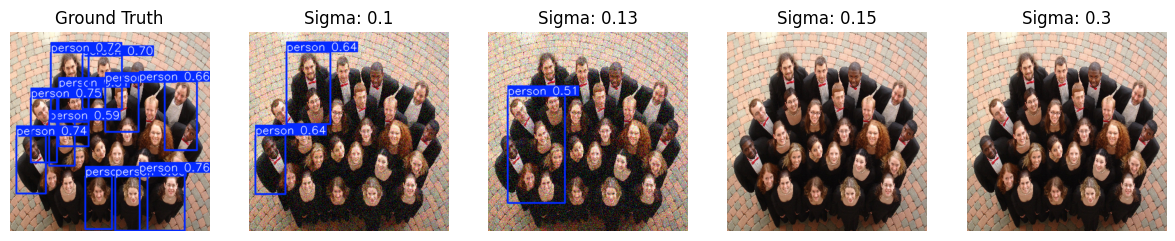

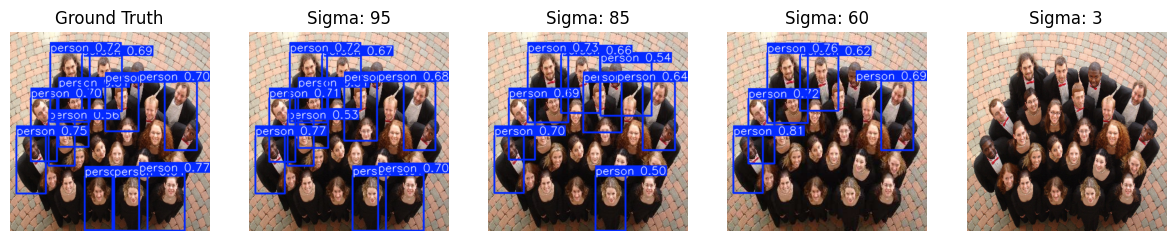

In [58]:

_show(SIGMA, annoted_gaussian)
_show(COMPRESSION, annoted_blur)

In [ ]:
from robustness_metrics import calculate_robustness_metrics

recall, avg_iou, tp_count = calculate_robustness_metrics(GT, predicted_jpeg[3], iou_threshold=0.5)

metrics_noise = [calculate_robustness_metrics(GT, pred, iou_threshold=0.5) for pred in predicted_gaussian]
metrics_jpeg = [calculate_robustness_metrics(GT, pred, iou_threshold=0.5) for pred in predicted_jpeg]

print(f"Total GT : {len(GT[0].boxes)}")
print(f"True Positives Count: {tp_count}")
print(f"Overall Recall @0.5: {recall:.4f} ({tp_count}/{len(GT[0].boxes)})")
print(f"Average IoU of True Positives: {avg_iou:.4f}")

Total GT : 11
True Positives Count: 5
Overall Recall @0.5: 0.4545 (5/11)
Average IoU of True Positives: 0.9534


In [ ]:
import matplotlib.pyplot as plt
# ... (Assuming df_final is your Pandas DataFrame)

plt.figure(figsize=(10, 6))
plt.plot(df_final['Degradation Level (e.g., QF/Sigma)'], df_final['Overall Recall @0.5'], 
         marker='o', label='Overall Recall')
plt.plot(df_final['Degradation Level (e.g., QF/Sigma)'], df_final['Average IoU of TP'], 
         marker='x', label='Average IoU')

plt.xlabel('Degradation Level (Lower QF or Higher Sigma = More Noise)')
plt.ylabel('Metric Score')
plt.title('Model Robustness Against Image Degradation')
plt.legend()
plt.grid(True)
plt.show()